In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from apyori import apriori

import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
data = pd.read_csv("../data/rawdata/spotify_dataset.csv", sep=',', engine='python', quotechar='"', error_bad_lines=False)

/tmp/ipykernel_3811/644016736.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv("../data/rawdata/spotify_dataset.csv", sep=',', engine='python', quotechar='"', error_bad_lines=False)
Skipping line 306: ',' expected after '"'
Skipping line 307: ',' expected after '"'
Skipping line 851: ',' expected after '"'
Skipping line 2039: ',' expected after '"'
Skipping line 2247: ',' expected after '"'
Skipping line 2553: ',' expected after '"'
Skipping line 2724: ',' expected after '"'
Skipping line 2725: ',' expected after '"'
Skipping line 2726: ',' expected after '"'
Skipping line 2727: ',' expected after '"'
Skipping line 2728: ',' expected after '"'
Skipping line 2729: ',' expected after '"'
Skipping line 3284: ',' expected after '"'
Skipping line 3300: ',' expected after '"'
Skipping line 5111: ',' expected after '"'
Skipping line 5130: ',' expected after '"'
Skipping line 51

In [3]:
df = data.copy()
df.isna().sum()

user_id             0
artistname      33532
trackname          85
playlistname       41
dtype: int64

In [4]:
df.dtypes

user_id         object
artistname      object
trackname       object
playlistname    object
dtype: object

As we can see there are no missing values

### TMP: Quick handling of NA values
As a quick solution, these are removed

In [5]:
df = df.dropna()

## Exploratory data analysis
First I will look into the different users in the dataset and see if we have some which might be unwanted.

In [6]:
# Drop duplicates 
df = df.drop_duplicates()

In [7]:
df["user_id"].nunique()

15906

In [8]:
df.groupby("user_id")["user_id"].value_counts()[:10].to_frame()

user_id
user_id                          user_id                                  
00055176fea33f6e027cd3302289378b 00055176fea33f6e027cd3302289378b      119
0007f3dd09c91198371454c608d47f22 0007f3dd09c91198371454c608d47f22       97
000b0f32b5739f052b9d40fcc5c41079 000b0f32b5739f052b9d40fcc5c41079      270
000c11a16c89aa4b14b328080f5954ee 000c11a16c89aa4b14b328080f5954ee      706
00123e0f544dee3ab006aa7f1e5725a7 00123e0f544dee3ab006aa7f1e5725a7    18369
00139e9cb50fb309549e1561b476226d 00139e9cb50fb309549e1561b476226d      456
00152c870313100559aad7b097d9c1f5 00152c870313100559aad7b097d9c1f5        1
00154ec9dd1acd4ebfb521629dcb3948 00154ec9dd1acd4ebfb521629dcb3948     1273
001599a07cb8ef5f114a9fcf4e0e2757 001599a07cb8ef5f114a9fcf4e0e2757        8
0019363a0d57e94d39988c31eeb8d015 0019363a0d57e94d39988c31eeb8d015      229

As we see there are some users with alot more entries than others. These will be explored more detailed

In [9]:
df.loc[df["user_id"] == "4398de6902abde3351347b048fcdc287"]['playlistname'].nunique()

29

As we see the most prevalant user only has 29 unique playlists. Hence the density of each playlist is very high. Later on this will make it hard to find correlations and rules between different artists which are strong using apriori. We will have to see if this is the case for sevaral other users

In [10]:
df.groupby("user_id")["playlistname"].nunique()

user_id
00055176fea33f6e027cd3302289378b     1
0007f3dd09c91198371454c608d47f22     3
000b0f32b5739f052b9d40fcc5c41079     7
000c11a16c89aa4b14b328080f5954ee    20
00123e0f544dee3ab006aa7f1e5725a7    32
                                    ..
ffe32d5412269f3041c58cbf0dde3306     2
ffec270eae226caa14ddaef291d73fff     3
fff60baf392613ed33f745b89a9b38f7    41
fff616055993498d6127f3f467cf9f2b    20
fff77dadf8528083c920b9c018847e8b     1
Name: playlistname, Length: 15906, dtype: int64

In [11]:
df["number_of_playlists"] = df.groupby("user_id")["playlistname"].transform('nunique')
df.head()

user_id                        artistname  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   
1  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
2  9cc0cfd4d7d7885102480dd99e7a90d6                      Tiffany Page   
3  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
4  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   

                                           trackname    playlistname  \
0               (The Angels Wanna Wear My) Red Shoes  HARD ROCK 2010   
1  (What's So Funny 'Bout) Peace, Love And Unders...  HARD ROCK 2010   
2                                   7 Years Too Late  HARD ROCK 2010   
3                              Accidents Will Happen  HARD ROCK 2010   
4                                             Alison  HARD ROCK 2010   

   number_of_playlists  
0                    2  
1                    2  
2                    2  
3                    2  
4                    2

In [12]:
df["number_of_songs"] = df.groupby("user_id")["trackname"].transform('nunique')
df.head()

In [ ]:
df["number_of_artist"] = df.groupby("user_id")["artistname"].transform('nunique')
df.head()

user_id                        artistname  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   
1  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
2  9cc0cfd4d7d7885102480dd99e7a90d6                      Tiffany Page   
3  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
4  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   

                                           trackname    playlistname  \
0               (The Angels Wanna Wear My) Red Shoes  HARD ROCK 2010   
1  (What's So Funny 'Bout) Peace, Love And Unders...  HARD ROCK 2010   
2                                   7 Years Too Late  HARD ROCK 2010   
3                              Accidents Will Happen  HARD ROCK 2010   
4                                             Alison  HARD ROCK 2010   

   number_of_playlists  number_of_songs  number_of_artist  
0                    2              104                27  
1                    2              104                27  
2                    2              104                27  
3                    2              104                27  
4                    2              104                27

<AxesSubplot:ylabel='Frequency'>

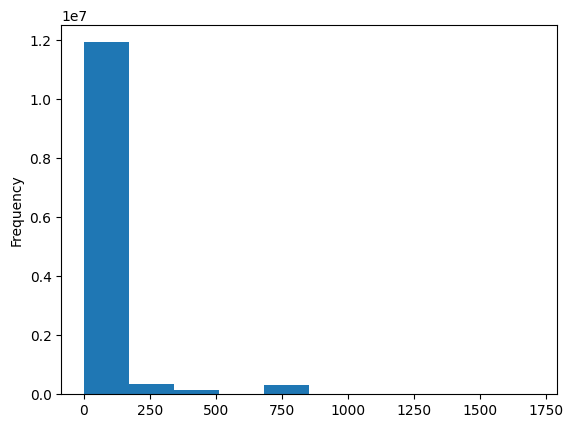

In [ ]:
df["avg_artist_per_playlist"] = df["number_of_artist"] / df["number_of_playlists"]
df['avg_artist_per_playlist'].plot(kind='hist')

As we can see, there are users that uses which has more than 125 artist in a playlist. To make the dataset smaller, we will remove these 

## Removing unwanted users

In [ ]:
df = df.loc[df["avg_artist_per_playlist"] < 25]
df.size

54094808

<AxesSubplot:ylabel='Frequency'>

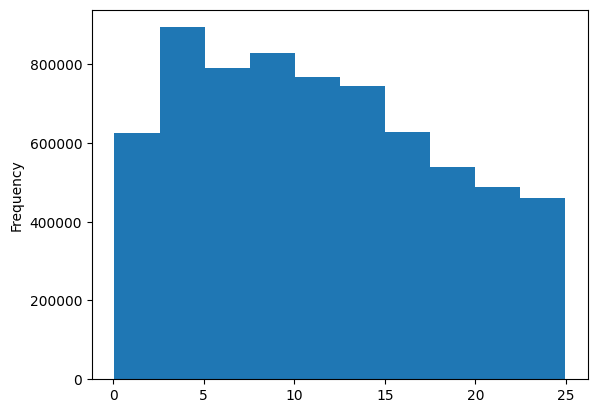

In [ ]:
df["avg_artist_per_playlist"].plot(kind='hist')

In [ ]:
df = df[["user_id", "artistname", "playlistname"]]
df = df.drop_duplicates()
df.to_csv("../data/data_sources/spotify.csv",encoding="utf-8", mode="w", index=False)

NameError: name 'df' is not defined

In [ ]:
def read_transactions_from_file():
    transactions = []
    with open("../data/transactions.txt", "r") as file:
        text = file.read()
        transactions = text.split('\n')
    return transactions

trans = read_transactions_from_file()

print(trans[0])

import pandas as pd
df = pd.DataFrame(trans, columns=["Content"])

import sqlite3

conn = sqlite3.connect("../src/database/sqlite.db")
c = conn.cursor()

df.to_sql("Playlist", conn, if_exists='replace', index=True)

Elvis Costello,Elvis Costello & The Attractions,Tiffany Page,Lissie,Paul McCartney,Joe Echo,The Breakers,The Coronas,Crowded House,Joshua Radin,Cocktail Slippers,Crosby, Stills & Nash,The Len Price 3,Paul McCartney & Eric Clapton,Noah And The Whale,Noel Gallagher's High Flying Birds,Pearl Jam,Tom Petty And The Heartbreakers,Bruce Springsteen,Madness,Spector,Miles Kane,Tom Petty,Biffy Clyro,Elbow,Oasis,Thunderclap Newman


12020